In [0]:
!ls "/kaggle/input/pokemon-images-dataset/pokemon/pokemon"
!mkdir "/kaggle/save"
!ls "/kaggle"

(819, 128, 128, 3)


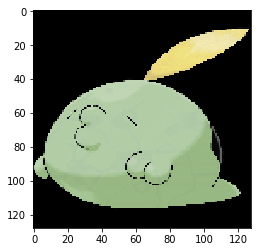

In [13]:
import os
import glob
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.backend.tensorflow_backend import set_session

FilePath = "/kaggle/input/pokemon-images-dataset/pokemon/pokemon"
SavePath = "/kaggle/save"
DirectoryList = []

for dirname, _, filenames in os.walk(FilePath):
    
    for filename in filenames:
        
        DirectoryList.append(os.path.join(dirname, filename))

        
PokemonImage = []

for number in range (len(DirectoryList)):
    
    Image = load_img(DirectoryList[number], target_size = (128, 128))
    Image = img_to_array(Image)
    PokemonImage.append(Image/255.)

print (np.shape(PokemonImage))
plt.imshow (PokemonImage[10])

In [ ]:
# Define Build Function Toolkit
def Build_Shuffle_BatchData (BatchSize, Input) :
    
    np.random.shuffle (Input)
    TempGetImage = Input[0 : BatchSize]
    Output = TempGetImage
    
    return Output


def Build_Generator (inputs): 
    with tf.variable_scope("Generator_Variable"):
        
        output = tf.layers.dense(inputs, 4*4*1024)
        output = tf.reshape(output, [-1, 4, 4, 1024])
        output = tf.nn.relu (output)
    
        output = tf.layers.conv2d_transpose(output, 1024, Kernel_Size, strides = (2, 2), 
                                            padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.relu (output)
        
        output = tf.layers.conv2d_transpose(output, 512, Kernel_Size, strides = (2, 2), 
                                            padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.relu (output)
        
        output = tf.layers.conv2d_transpose(output, 256, Kernel_Size, strides = (2, 2), 
                                            padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.relu (output)
        
        output = tf.layers.conv2d_transpose(output, 128, Kernel_Size, strides = (2, 2), 
                                            padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.relu (output)
        
        output = tf.layers.conv2d_transpose(output, 3, Kernel_Size, strides = (2, 2), 
                                            padding = "SAME")
        output = tf.tanh (output)
        
    return output
 
    
def Build_Discriminator (inputs, reuse = None):
    with tf.variable_scope("Discriminator_Variable") as scope:
        
        if reuse:
            scope.reuse_variables()

        output = tf.layers.conv2d(inputs, 128, Kernel_Size, strides = (2, 2), 
                                  padding = "SAME", use_bias = True)
        output = tf.nn.leaky_relu (output)
        # 128 128 8
        
        output = tf.layers.conv2d(output, 256, Kernel_Size, strides = (2, 2), 
                                  padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.leaky_relu (output)
        # 64 64 16
        
        output = tf.layers.conv2d(output, 512, Kernel_Size, strides = (2, 2), 
                                  padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.leaky_relu (output)
        # 32 32 32
        
        output = tf.layers.conv2d(output, 1024, Kernel_Size, strides = (2, 2), 
                                  padding = "SAME", use_bias = False)
        output = tf.layers.batch_normalization(output, training = IsTraining)
        output = tf.nn.leaky_relu (output)
        # 16 16 64
        
        output = tf.layers.flatten(output)
        output = tf.layers.dense(output, 1, activation = None)
        output = tf.nn.leaky_relu (output)
        
    return output
 
    
def Build_GetNoise (batch_size, noise_size):
    return np.random.uniform(-1.0, 1.0, size=[batch_size, noise_size])



TotalEpoch= 3
BatchSize = 50
NoiseSize = 100
LearningRate1 = 0.0002
Kernel_Size = (3, 3)

tf.reset_default_graph ()
X = tf.placeholder(tf.float32, [None, 128, 128, 3])
Z = tf.placeholder(tf.float32, [None, NoiseSize])
IsTraining = tf.placeholder(tf.bool)
dropout_rate = tf.placeholder(tf.float32)

DiscGlobalStep = tf.Variable(0, trainable = False, name = "DiscGlobal")
GeneGlobalStep = tf.Variable(0, trainable = False, name = "GeneGlobal")
 
Fake = Build_Generator(Z)
DiscReal = Build_Discriminator(X)
DiscGene = Build_Discriminator(Fake, True)

print (np.shape(Fake), np.shape(DiscReal), np.shape(DiscGene))
 
    
LossDiscReal = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits \
                             (logits=DiscReal, labels=tf.ones_like(DiscReal)))
LossDiscGene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits \
                             (logits=DiscGene, labels=tf.zeros_like(DiscGene)))

LossDisc = LossDiscReal + LossDiscGene
LossGene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits \
                         (logits=DiscGene, labels=tf.ones_like(DiscGene)))

DiscVars = tf.get_collection \
            (tf.GraphKeys.TRAINABLE_VARIABLES, scope = "Discriminator_Variable")
GeneVars = tf.get_collection \
            (tf.GraphKeys.TRAINABLE_VARIABLES, scope = "Generator_Variable")
UpdateOps = tf.get_collection (tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(UpdateOps):
    TrainDisc = tf.train.AdamOptimizer(LearningRate1, beta1 = 0.5) \
                            .minimize(LossDisc, var_list=DiscVars)
    TrainGene = tf.train.AdamOptimizer(LearningRate1, beta1 = 0.5) \
                            .minimize(LossGene, var_list=GeneVars)

    
    
    
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(TotalEpoch):
        
        LossDiscVal = 0 
        LossGeneVal = 0

        for i in range(int(891/BatchSize)):
            
            BatchImage = Build_Shuffle_BatchData (BatchSize, PokemonImage)
            Noise = Build_GetNoise(BatchSize, NoiseSize)
            
            sess.run(TrainDisc, 
                     feed_dict = {X: BatchImage, Z: Noise, IsTraining: True})
            LossDiscVal = sess.run(LossDisc, 
                                   feed_dict = {X: BatchImage, Z: Noise, IsTraining: True})
            
            sess.run(TrainGene, 
                     feed_dict = {X: BatchImage, Z: Noise, IsTraining: True})
            LossGeneVal = sess.run(LossGene, 
                                   feed_dict = {X: BatchImage, Z: Noise, IsTraining: True})

        
        if (epoch+1) % 10 == 0 :
            
            print('Epoch:', '%04d  ' %(epoch+1))
            print('Discriminator loss: {:.4}  '.format(LossDiscVal))
            print('Generator loss:     {:.4}  '.format(LossGeneVal))
            
            Noise = Build_GetNoise(10, NoiseSize)
            Samples1 = sess.run(Fake, feed_dict = {Z: Noise, IsTraining: False})

            fig, ax = plt.subplots(1, 5, figsize=(30, 30))

            for i in range(5) :
                ax[i].imshow(Samples1[i])

            plt.show ()
            plt.close(fig)

(?, 128, 128, 3) (?, 1) (?, 1)
